In [1]:
# Basic imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

## Getting Started
* Download the oct_2024.snappy.parquet and data_dict.csv files from the provided link
* data_dict.csv contains a description of every column in oct_2024.snappy.parquet
* oct_2024.snappy.parquet is a parquet file, which is a common file type, with numerous advantages over csv 
    * Compression
    * Schema preservation
    * Columnar format, you can read only the columns you need, very handy when you are dealing with very wide tables, or columns containing lots of data, such as text extracts or arrays and only want the associated metadata
    
## A Note on the Data
This dataset is constructed from multiple internal tables at Auto Trader with minimal cleaning, and so is representative of real data you would find out in the wild. This does mean that there are plenty of nulls and some oddities, for example there is one entry that has taken >4 years to sell. 

Good feature cleaning and engineering will be critical in achieving a good result. Some features have extremely high cardinality (e.g. derivative), you may want to find ways of reducing this, or finding alternative ways to represent the data.

Sometimes the data that is easy to pull is not the data that you want for the problem, think carefully about the features you have been provided and whether a production grade would would have access to them at inference time. Also consider any biases present in the dataset. This data is looking at a set of subset of sales that occured in October 2024, and is mainly last-seen properties of the advert.

In [2]:
# CHANGE TO WHERE YOUR FILE IS STORED
dict_path = "./MMU_Hack_Data/data_dict.csv"
data_path = "./MMU_Hack_Data/oct_2024.snappy.parquet"

# Read in data
data_dict_df = pd.read_csv(dict_path)
raw_data_df = pd.read_parquet(data_path)

In [3]:
pd.set_option('display.max_colwidth', None) # Prevents truncation of long text columns
data_dict_df

,Field,Description
0,stock_item_id,Unique ID of the advert e.g. 8a42801e86dad35a0186dd181f956cb5
1,last_date_seen,The date the vehicle was last seen advertised on Auto Trader e.g. 2023-01-31
2,first_date_seen,The first date the vehicle was listed on Auto Trader
3,days_to_sell,The difference in days between first_date_seen and last_date_seen
4,first_retailer_asking_price,The price the advert had when first created. This may have been a temp holding price before it went live.
5,last_retailer_asking_price,The last seen price
6,can_home_deliver,This advert is able to be delivered to the buyers home
7,reviews_per_100_advertised_stock_last_12_months,"How many reviews the seller has recieved in the last 12 months per 100 stock advertised, i.e. 200 stock advertised over the whole year, 150 reviews 150/2= 75"
8,segment,Whether the seller is a Franchise or Independent retailer
9,seats,Number of seats in the vehicle


In [4]:
raw_data_df.head(4)

,stock_item_id,last_date_seen,first_date_seen,days_to_sell,first_retailer_asking_price,last_retailer_asking_price,can_home_deliver,reviews_per_100_advertised_stock_last_12_months,segment,seats,...,first_registration_date,attention_grabber,manufacturer_approved,price_indicator_rating,adjusted_retail_amount_gbp,predicted_mileage,number_of_images,first_image_label,advert_quality,postcode_area
0,33e3749b79a2847010ec1ad4716745393a2fd6b7d9db8d0563363085e1435502,2024-10-07,2022-10-12,726,24495,18995,False,0.3,Independent,5.0,...,2016-09-09,None,False,GOOD,18716.0,73842.0,11,FRONT_RIGHT,72,BT
1,cbf6f80e01e939aa017a9641d02f5cc24f78c3e69d9a742fe53edf30116053e6,2024-10-25,2023-05-13,531,16990,12990,False,0.9,Franchise,5.0,...,2021-01-14,£750 deposit contribution*,True,GOOD,13110.0,22740.0,12,FRONT_RIGHT,55,HA
2,c49040c0388b7533accbf7d4db144efbe7b2a251256b3bb3bdab3253f0e23abe,2024-10-05,2023-07-31,432,14481,11913,False,9.1,Independent,5.0,...,2016-12-17,SAT NAV • REAR CAMERA,False,GOOD,11873.0,55729.0,38,FRONT_RIGHT,41,BS
3,eacc77fecac6a43b328d0cbb16c192baa0654284a37b7d5219d81ff255124f5b,2024-10-21,2023-09-18,399,61000,36500,False,2.9,Franchise,5.0,...,2023-05-15,8.9 PERCENT APR AVAILABLE,False,GOOD,36809.0,10689.0,49,FRONT_RIGHT,71,PR


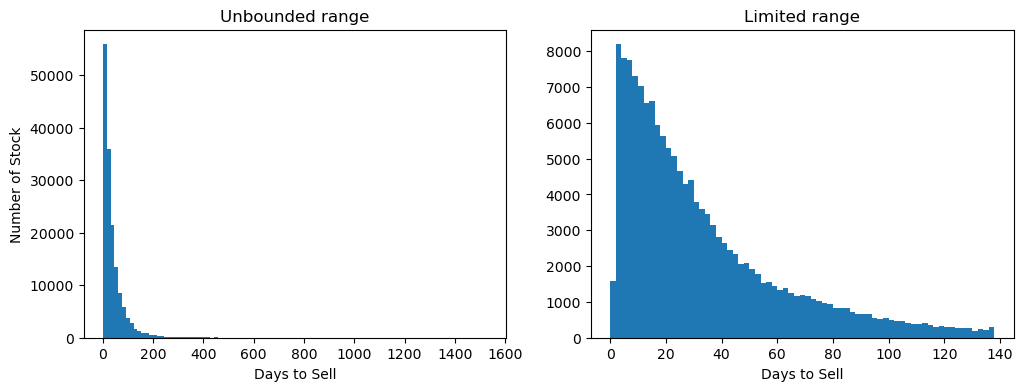

In [5]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].hist(raw_data_df['days_to_sell'], bins=100)
ax[1].hist(raw_data_df['days_to_sell'], bins=np.arange(0,140,2))

ax[0].set_xlabel('Days to Sell')
ax[1].set_xlabel('Days to Sell')

ax[0].set_ylabel('Number of Stock')
ax[0].set_title('Unbounded range')
ax[1].set_title('Limited range')
plt.show()
plt.close()

## Example data cleaning

In [6]:
# Handles Nulls from New cars in the data
raw_data_df['first_registration_date'] = raw_data_df['first_registration_date'].fillna(raw_data_df['last_date_seen'])
# Some registration dates are extremely old (i.e. 1000s of years) and can cause issues 
clean_dates_df = raw_data_df.loc[raw_data_df['first_registration_date']>dt.date(1950,1,1)].copy()

clean_dates_df['days_old'] = (clean_dates_df['last_date_seen'] - clean_dates_df['first_registration_date']).dt.days
clean_dates_df['days_old']

0         2950
1         1380
2         2849
3          525
4         2042
          ... 
155671    4049
155672    2687
155673    3944
155674    1204
155675    4063
Name: days_old, Length: 155668, dtype: int64